<a href="https://colab.research.google.com/github/jensullrich/DataScienceSS20/blob/Project/Project/Project_NLP_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup


## 1.1 Installation

Zuerst werden einige Pakete installiert, die in Colab nicht standardmäßig vorhanden sind. Alles weitere sollte vorinstalliert sein. 

Als Framework wird Tensorflow in der Version 2.3 verwendet. 

Als Architektur wird die, in der Vorlesung vorgestellte, Architektur BERT verwendet. Es wird die fertige Implementierung bert-for-tf2 in der aktuellen Version 0.14.5 genutzt. 
Quelle: https://pypi.org/project/bert-for-tf2/

Vortrainierte Modelle werden von Tensorflow-Hub heruntergeladen. 
Quelle: https://tfhub.dev/s?q=bert


In [1]:
!pip install tensorflow
!pip install --upgrade tensorflow-hub
!pip install bert-for-tf2
#!pip install sentencepiece

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.8.0)


## 1.2 Imports

Hier befinden sich gesammelt alle Imports des Projekts.

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, Average
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import bert
from sklearn.preprocessing import StandardScaler

## 1.3 Cloud

Das Projekt ist in Google Colab entwickelt und getestet worden, sollte aber auch lokal funktionieren, wenn eine passende GPU vorhanden ist.

In [3]:
#check if notebook runs in colab
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone -b Project https://github.com/jensullrich/DataScienceSS20/
  path='DataScienceSS20/Project'

running in Colab: True
fatal: destination path 'DataScienceSS20' already exists and is not an empty directory.


Da das BERT Modell sehr groß ist, wird sehr viel GPU-Speicher benötigt. Deshalb wird hier am Anfang geprüft ob eine GPU mit ausreichend Speicher zugeteilt wurde. Es sollten 16GB sein, ist das nicht der Fall sollte die Runtime resettet werden, bis eine passende GPU zur Verfügung steht.

In [4]:
#check out the GPU
!nvidia-smi

Sat Aug  8 18:00:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Exploring Data

Die Daten werden zunächst explorativ untersucht. Das Traininsset besteht aus 7613 Tweets, die mit 0 oder 1 für "No Disaster" oder "Disaster" gelabelt sind. Zusätzlich gibt es bei einigen Tweets noch die Location und ein Keyword. Diese können aber auch fehlen.

Das Testset enthält 3263 Tweets ohne Label. 

In [5]:
# read the given csv files
train=pd.read_csv(path + '/DATA/train.csv', index_col='id')
test=pd.read_csv(path + '/DATA/test.csv', index_col='id')
submission = pd.read_csv(path + '/DATA/sample_submission.csv')

In [6]:
print(train.shape)
print(test.shape)

print(train.head())
print(test.head())

(7613, 4)
(3263, 3)
   keyword location                                               text  target
id                                                                            
1      NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
4      NaN      NaN             Forest fire near La Ronge Sask. Canada       1
5      NaN      NaN  All residents asked to 'shelter in place' are ...       1
6      NaN      NaN  13,000 people receive #wildfires evacuation or...       1
7      NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1
   keyword location                                               text
id                                                                    
0      NaN      NaN                 Just happened a terrible car crash
2      NaN      NaN  Heard about #earthquake is different cities, s...
3      NaN      NaN  there is a forest fire at spot pond, geese are...
9      NaN      NaN           Apocalypse lighting. #Spokane #wildfires
1

## 2.1 NaN Values

Laut Beschreibung können sowohl Keyword, als auch Location fehlen. Es wird also zunächst untersucht wie viele Werte fehlen. Beim Keyword ist der Anteil an fehlenden Werten sehr gering, was für eine Verwendung spricht. Bei rund einem Drittel der Daten fehlt die Location, diese ist somit eher schlecht als Feature geeignet.

In [7]:
training_has_keyword = train["keyword"].notna().value_counts(normalize=True)
training_has_location = train["location"].notna().value_counts(normalize=True)
test_has_keyword = test["keyword"].notna().value_counts(normalize=True)
test_has_location = test["location"].notna().value_counts(normalize=True)

try:
    print(f'{training_has_keyword[True]*100:.1f}', "% of training data have keyword,", f'{(training_has_keyword[False])*100:.1f}', "% of keywords are missing")
    print(f'{training_has_location[True]*100:.1f}', "% of training data have location,", f'{(training_has_location[False])*100:.1f}', "% of locations are missing")
    print(f'{test_has_keyword[True]*100:.1f}', "% of test data have keyword,", f'{(test_has_keyword[False])*100:.1f}', "% of keywords are missing")
    print(f'{test_has_location[True]*100:.1f}', "% of test data have location,", f'{(test_has_location[False])*100:.1f}', "% of locations are missing")
except KeyError:
    print("No NaN values or they have already been replaced")

99.2 % of training data have keyword, 0.8 % of keywords are missing
66.7 % of training data have location, 33.3 % of locations are missing
99.2 % of test data have keyword, 0.8 % of keywords are missing
66.1 % of test data have location, 33.9 % of locations are missing


Die fehlenden Werte bekommen die aussagekräftigeren Einträge 'missing_keyword' bzw. 'missing_location'.

In [8]:
print("Replacing NaN values with missing_keyword and missing_location")
train["keyword"] = train["keyword"].fillna('missing_keyword')
train["location"] = train["location"].fillna('missing_location')
test["keyword"] = test["keyword"].fillna('missing_keyword')
test["location"] = test["location"].fillna('missing_location')

Replacing NaN values with missing_keyword and missing_location


## 2.2 Duplicate Values

Im Trainingsdatensatz kommen einige Tweets mehrfach vor. Bei Zeilen die komplett doppelt vorkommen, inklusive Target, Keyword und Location, werden nur die Duplikate gelöscht. Bei Zeilen, wo nur der Text übereinstimmt, werden alle gelöscht, da vor allem ein verschiedenes Target das Modell stören könnte. Insgesamt werden so 158 Zeilen gelöscht.


In [9]:
#duplicates = train[train.duplicated()]
# remove complete duplicates, keep only the first occurence
print(train.shape)
train.drop_duplicates(keep='first', inplace=True)
print(train.shape)
# check other duplicates
train.drop_duplicates('text', keep=False, inplace=True)
print(train.shape)
#duplicates = train[train.duplicated(['text'], keep=False)]
#duplicates.shape


(7613, 4)
(7561, 4)
(7455, 4)


## 2.3 Exploration of keyword and location

Als nächstes werden die Zusatzfeatures Keyword und Location nochmals untersucht. Es gibt 221 verschiedene Keywords und 3306 verschiedene Locations. Wie schon bei den fehlenden Werten stellt sich auch hier heraus, dass das Keyword durchaus hilfreich sein könnte um die Tweets zu klassifizieren. Die Location ist eher ungeeignet, da es zu viele verschiedene Werte gibt, jeder Wert nur wenige Male vorkommt und zusätzlich viele Werte fehlen.

In [10]:
print("We have", len(train["keyword"]), "tweets with", train["keyword"].nunique(), "unique keywords.")
print("We have", len(train["location"]), "tweets with", train["location"].nunique(), "unique locations.")

We have 7455 tweets with 222 unique keywords.
We have 7455 tweets with 3307 unique locations.


In [11]:
grouped = train.groupby(train["keyword"])
grouped.size().sort_values()

grouped = train.groupby(train["location"])
grouped.target.sum().sort_values(ascending=False).head(10)

location
missing_location    1030
USA                   67
United States         27
Mumbai                18
Nigeria               17
India                 17
New York              16
London                16
Washington, DC        15
UK                    15
Name: target, dtype: int64

## 2.4 Meta Features

Aus dem Text des Tweets lassen sich noch einige Features bestimmen, die eventuell nützlich sein könnten.


*   Anzahl der Wörter
*   Anzahl der verschiedenen Wörter
*   Anzahl an URLs
*   Durchschnittliche länge der Wörter
*   Anzahl der Buchstaben
*   Anzahl der Hashtags
*   Anzahl der Erwähnungen mit @
*   keyword_target_mean ist der durchschnittliche Targetwert, bei Tweets mit diesem Keyword



In [12]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# keyword target mean
train['keyword_target_mean'] = train.groupby('keyword')['target'].transform('mean')
test['keyword_target_mean'] = test['keyword'].apply(lambda x: train.loc[train['keyword'] == x, 'keyword_target_mean'].iloc[0])

In [13]:
train.sort_values(by='keyword_target_mean', ascending=True).head(100)
#test.sort_values(by='keyword_target_mean', ascending=False).head(10)

,keyword,location,text,target,word_count,unique_word_count,url_count,mean_word_length,char_count,hashtag_count,mention_count,keyword_target_mean
id,,,,,,,,,,,,
178,aftershock,United States,&gt;&gt; $15 Aftershock : Protect Yourself and...,0,16,16,1,7.187500,130,2,1,0.000000
146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0,8,8,0,5.250000,49,0,1,0.000000
149,aftershock,304,'The man who can drive himself further once th...,0,20,17,0,4.500000,110,0,0,0.000000
151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0,16,14,2,7.687500,138,6,1,0.000000
153,aftershock,304,'There is no victory at bargain basement price...,0,11,11,0,5.727273,73,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8356,ruin,Garrett,like why on earth would you want anybody to be...,0,17,17,0,5.000000,101,0,0,0.027027
8375,ruin,"Winnipeg, Manitoba",Why do u ruin everything? @9tarbox u ruined t...,0,21,18,0,4.190476,109,0,1,0.027027
8382,ruin,Florida Forever,RT to ruin @connormidd 's day. http://t.co/kr...,0,7,7,1,6.714286,54,0,1,0.027027


In [14]:
train['char_count'].max()

157

In [15]:
#define and scale our added features
train_meta_input = StandardScaler().fit_transform(train.iloc[:, 4:])
test_meta_input = StandardScaler().fit_transform(test.iloc[:, 3:])

META_DIM = train_meta_input.shape[1]
print(META_DIM)

8


# 3. Build Model

In [16]:
def bert_encode(tweet_texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in tweet_texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [17]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    meta_input = Input(shape=(META_DIM,), dtype=tf.float32, name='meta_input')

    pool_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    x = Dense(32,activation='relu')(pool_output)
    x = Dropout(0.2)(x)
    x = Concatenate()([x, meta_input])
    x = Dropout(0.2)(x)

    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids, meta_input], outputs=out)
    opt = tf.keras.optimizers.Adam(lr=1e-5)
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 3.1 Build Base Model

In [18]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 4.58 s, sys: 952 ms, total: 5.53 s
Wall time: 5.45 s


In [41]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
FullTokenizer=bert.bert_tokenization.FullTokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

NameError: ignored

Die Sequence-Length sollte so klein wie möglich und so groß wie nötig sein, da eine größere Länge den Speicherbedarf erhöht.

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

# 3.2 Build Large Model

In [18]:
%%time
module_large_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_large_layer = hub.KerasLayer(module_large_url, trainable=True)

CPU times: user 8.74 s, sys: 2.14 s, total: 10.9 s
Wall time: 10.9 s


In [19]:
vocab_file = bert_large_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_large_layer.resolved_object.do_lower_case.numpy()
FullTokenizer=bert.bert_tokenization.FullTokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [20]:
train_input = bert_encode(train.text.values, tokenizer, max_len=150)
test_input = bert_encode(test.text.values, tokenizer, max_len=150)
train_labels = train.target.values

In [21]:
model_large = build_model(bert_large_layer, max_len=150)
model_large.summary()

checkpoint = ModelCheckpoint('model_large.h5', monitor='val_loss', save_best_only=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

# 4. Training

In [22]:
train_history = model.fit(
    [train_input, train_meta_input], train_labels, 
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=32
)

NameError: ignored

In [27]:
train_history = model_large.fit(
    [train_input, train_meta_input], train_labels, 
    validation_split=0.2,
    epochs=4,
    callbacks=[checkpoint],
    batch_size=18
)

Epoch 1/2
332/332 [==============================] - 454s 1s/step - loss: 0.4132 - accuracy: 0.8732 - val_loss: 0.4174 - val_accuracy: 0.8364
Epoch 2/2
332/332 [==============================] - 451s 1s/step - loss: 0.3909 - accuracy: 0.8843 - val_loss: 0.4172 - val_accuracy: 0.8357


# 5. Herausforderungen

Das Training zeigt bereits nach drei Epochen Anzeichen für Overfitting. Die Trainings-Accuracy nimmt stark zu, die Validation-Accuracy allerdings nicht. Es ist daher damit zu rechnen, dass sich auch die Ergebnisse des Test-Datensatzes mit weiteren Epochen nicht mehr verbessern oder sogar verschlechtern.

Allgemein lagen alle Ergebnisse nah beieinander zwischen 82% und 85%. Das beste Ergebnis des Testsets lag bei 0.84523.

Bessere Ergebnisse konnten mit größerer Batchsize erreicht werden, jedoch ist der GPU-Speicher hier limitierend. Die Herausforderung hierbei war es, die Batchsize so groß wie möglich einzustellen, ohne dass das Training mit einem Out-Of-Memory-Error abstürzt.

Bei 16GB Memory konnte eine maximale Batchsize von 18 erreicht werden. Dazu musste folgendes Optimiert werden:

*   verringerung der max_seq_len von 160 auf 150
*   aktivieren von NVidia AMP beim Optimizer
*   regelmäßiges Neustarten der Runtime

Folgendes könnte noch ausprobiert werden, wurde aber aufgrund des erhöhten Aufwandes und mangels funktionierender Implementationen noch nicht umgesetzt:

*   Gradient Accumulation -> Mini-Batches zu größeren Batches zusammenfügen



BERT Base vs. BERT Large

Mit BERT Large konnten allgemein etwas bessere Ergebnisse erzielt werden. Bei wenig verfügbarem Speicher bietet BERT Base allerdings eine gute Alternative.

In [23]:
model_large.load_weights('model_large.h5')
test_pred = model_large.predict([test_input, test_meta_input])
test['prediction'] = test_pred

Das folgende Diagramm zeigt, wie die Vorhersagen des Modells verteilt sind. Je größer die beiden Spitzen nahe 0 und 1 sind, desto sicherer entscheidet das Modell. 

Es scheint, dass es für das Modell einfacher ist, einen Tweet als "real Disaster" zu erkennen, als umgekehrt.

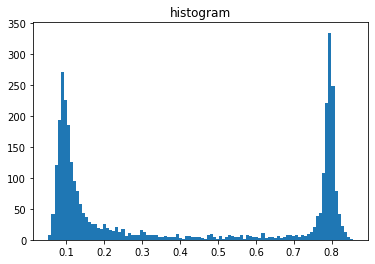

In [28]:
sorted = np.sort(test_pred, axis=0)
plt.hist(test_pred, bins = 100) 
plt.title("histogram") 
plt.show()

Mit dem folgenden Code sollten die "unsicheren" Vorhersagen betrachtet werden um noch Ideen für mögliche Verbesserungen zu finden. Es gab jedoch keine besonderen Auffälligkeiten.

In [25]:
print(test.shape)
uncertain = test[(test['prediction'] < 0.80)]
print(uncertain.shape)
uncertain = uncertain[(uncertain['prediction'] > 0.5)]
print(uncertain.shape)
uncertain.sort_values(by='keyword_target_mean', ascending=False).head(10)

(3263, 12)
(2873, 12)
(960, 12)


,keyword,location,text,word_count,unique_word_count,url_count,mean_word_length,char_count,hashtag_count,mention_count,keyword_target_mean,prediction
id,,,,,,,,,,,,
10761,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,17,17,1,7.058824,136,0,0,1.0,0.799649
3113,debris,Rochester Minnesota,BBC News - MH370: Reunion debris is from missi...,12,12,1,6.333333,87,0,0,1.0,0.799188
3143,debris,missing_location,With authorities ???increasingly confident??? ...,18,18,0,6.611111,136,0,0,1.0,0.798050
3148,debris,World,Top story: MH370: Reunion debris is from missi...,16,16,2,6.562500,120,0,0,1.0,0.798070
3151,debris,"Bristol, UK",Interesting MH370: Aircraft debris found on La...,20,20,1,5.850000,136,0,0,1.0,0.795278
3515,derailment,missing_location,Madhya Pradesh Train Derailment: Village Youth...,21,21,0,5.523810,136,0,0,1.0,0.781450
3538,derailment,Chicago,Great photo by the Tribune's Terrence Antonio ...,17,17,1,6.588235,128,0,0,1.0,0.799127
3545,derailment,missing_location,Green Line trains resume service after South S...,19,16,1,6.157895,135,0,0,1.0,0.796442
3546,derailment,missing_location,Madhya Pradesh Train Derailment: Village Youth...,21,21,0,5.523810,136,0,0,1.0,0.781450


# 6. Final Results

Abschließend werden die Vorhersagen, im geforderten Format in der submission.csv gespeichert. Diese kann dann heruntergeladen und bei Kaggle eingereicht werden. 

Außerdem kann das Modell in Google Drive gespeichtert werden.


In [26]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [26]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/INFM/DataScience/Project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [27]:
model_large.save(root_path + '/models/model_0808_sub12_best.h5') 